In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [7]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_REKLAME.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2012-1,414272875,2012-01-01
1,2012-2,212497427,2012-02-01
2,2012-3,87379126,2012-03-01
3,2012-4,191855563,2012-04-01
4,2012-5,182001995,2012-05-01


In [3]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/reklame.json', 'w') as f:
    json.dump(json_data, f) 

{"2012-01-01T00:00:00.000":414272875,"2012-02-01T00:00:00.000":212497427,"2012-03-01T00:00:00.000":87379126,"2012-04-01T00:00:00.000":191855563,"2012-05-01T00:00:00.000":182001995,"2012-06-01T00:00:00.000":95346601,"2012-07-01T00:00:00.000":247403088,"2012-08-01T00:00:00.000":223582211,"2012-09-01T00:00:00.000":155713325,"2012-10-01T00:00:00.000":135514150,"2012-11-01T00:00:00.000":503464863,"2012-12-01T00:00:00.000":143885249,"2013-01-01T00:00:00.000":130791618,"2013-02-01T00:00:00.000":135270125,"2013-03-01T00:00:00.000":248532819,"2013-04-01T00:00:00.000":236133700,"2013-05-01T00:00:00.000":229740726,"2013-06-01T00:00:00.000":153730762,"2013-07-01T00:00:00.000":227128925,"2013-08-01T00:00:00.000":159321697,"2013-09-01T00:00:00.000":241863564,"2013-10-01T00:00:00.000":196157537,"2013-11-01T00:00:00.000":148156075,"2013-12-01T00:00:00.000":168838974,"2014-01-01T00:00:00.000":139408487,"2014-02-01T00:00:00.000":160995093,"2014-03-01T00:00:00.000":257741462,"2014-04-01T00:00:00.000":948

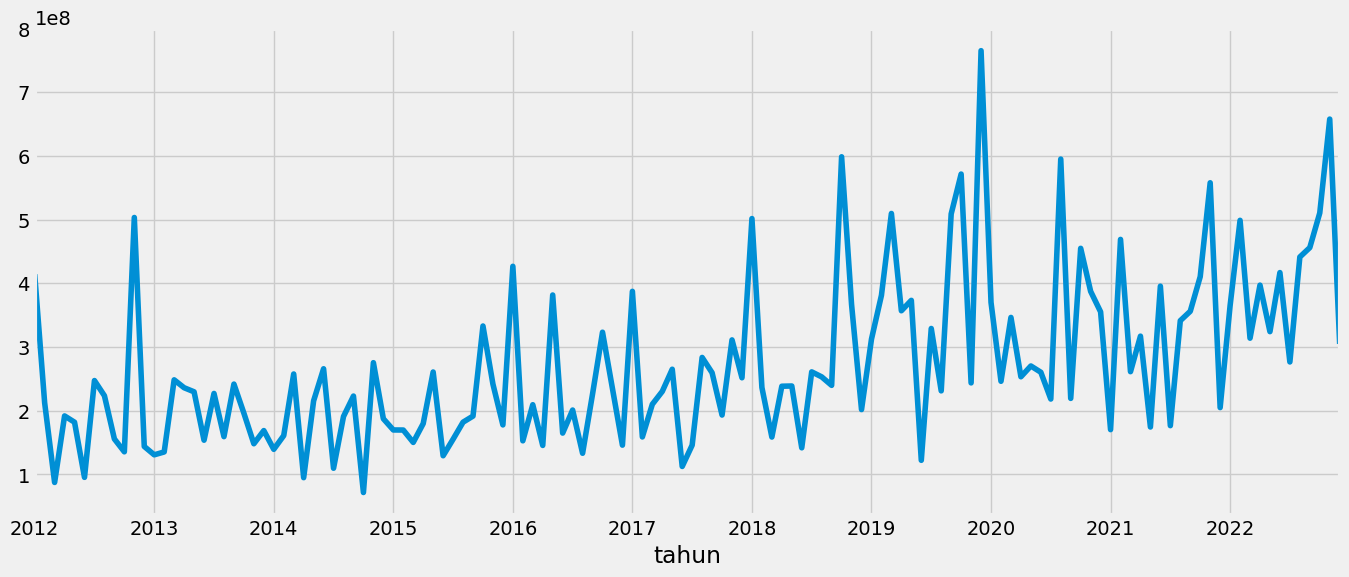

In [4]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [5]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [5]:
warnings.filterwarnings("ignore")  # specify to ignore warning messages
best_result = [0, 0, 10000000]
p_params = [0, 1, 2, 3]
d_params = [0, 1, 2]
q_params = [0, 1, 2, 3]
P_params = [0, 1, 2, 3]
D_params = [0, 1, 2]
Q_params = [0, 1, 2, 3]
for p in p_params:
    for d in d_params:
        for q in q_params:
            for P in P_params:
                for D in D_params:
                    for Q in Q_params:
                        param = [p, d, q]
                        param_seasonal = [P, D, Q, 12]
                        try:
                            mod = sm.tsa.statespace.SARIMAX(dts, order=param, seasonal_order=param_seasonal)
                            results = mod.fit()
                            if results.aic < best_result[2]:
                                if results.aic > 300:
                                    best_result = [param, param_seasonal, results.aic]
                                    print('Best Result:', best_result)
                        except:
                            continue
print('\nBest Result:', best_result)

Best Result: [[0, 0, 0], [0, 0, 1, 12], 5488.498333305077]
Best Result: [[0, 0, 0], [0, 0, 3, 12], 5405.973266659126]
Best Result: [[0, 0, 0], [0, 1, 0, 12], 4846.520475867548]
Best Result: [[0, 0, 0], [0, 1, 1, 12], 4821.594791040452]
Best Result: [[0, 0, 0], [0, 2, 0, 12], 4476.981897839595]
Best Result: [[0, 0, 0], [0, 2, 1, 12], 4396.752177323146]
Best Result: [[0, 0, 0], [1, 2, 1, 12], 4383.520181432562]
Best Result: [[0, 0, 0], [2, 2, 1, 12], 4370.6635714341055]
Best Result: [[0, 0, 0], [2, 2, 2, 12], 4370.232836312239]
Best Result: [[0, 0, 0], [3, 2, 1, 12], 4368.3820415243545]
Best Result: [[0, 0, 0], [3, 2, 2, 12], 4365.6191586471405]

Best Result: [[0, 0, 0], [3, 2, 2, 12], 4365.6191586471405]


In [7]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [15]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(0, 0, 0),seasonal_order=(3, 2, 2, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                  132
Model:             SARIMAX(3, 2, [1, 2], 12)   Log Likelihood               -1453.170
Date:                       Sun, 02 Apr 2023   AIC                           2918.340
Time:                               07:16:50   BIC                           2932.000
Sample:                           01-01-2012   HQIC                          2923.778
                                - 12-01-2022                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.6320      0.126    -12.943      0.000      -1.879      -1.385
ar.S.L24      -1.0270      0.228     -4.497      0.000      -1.475      -0.

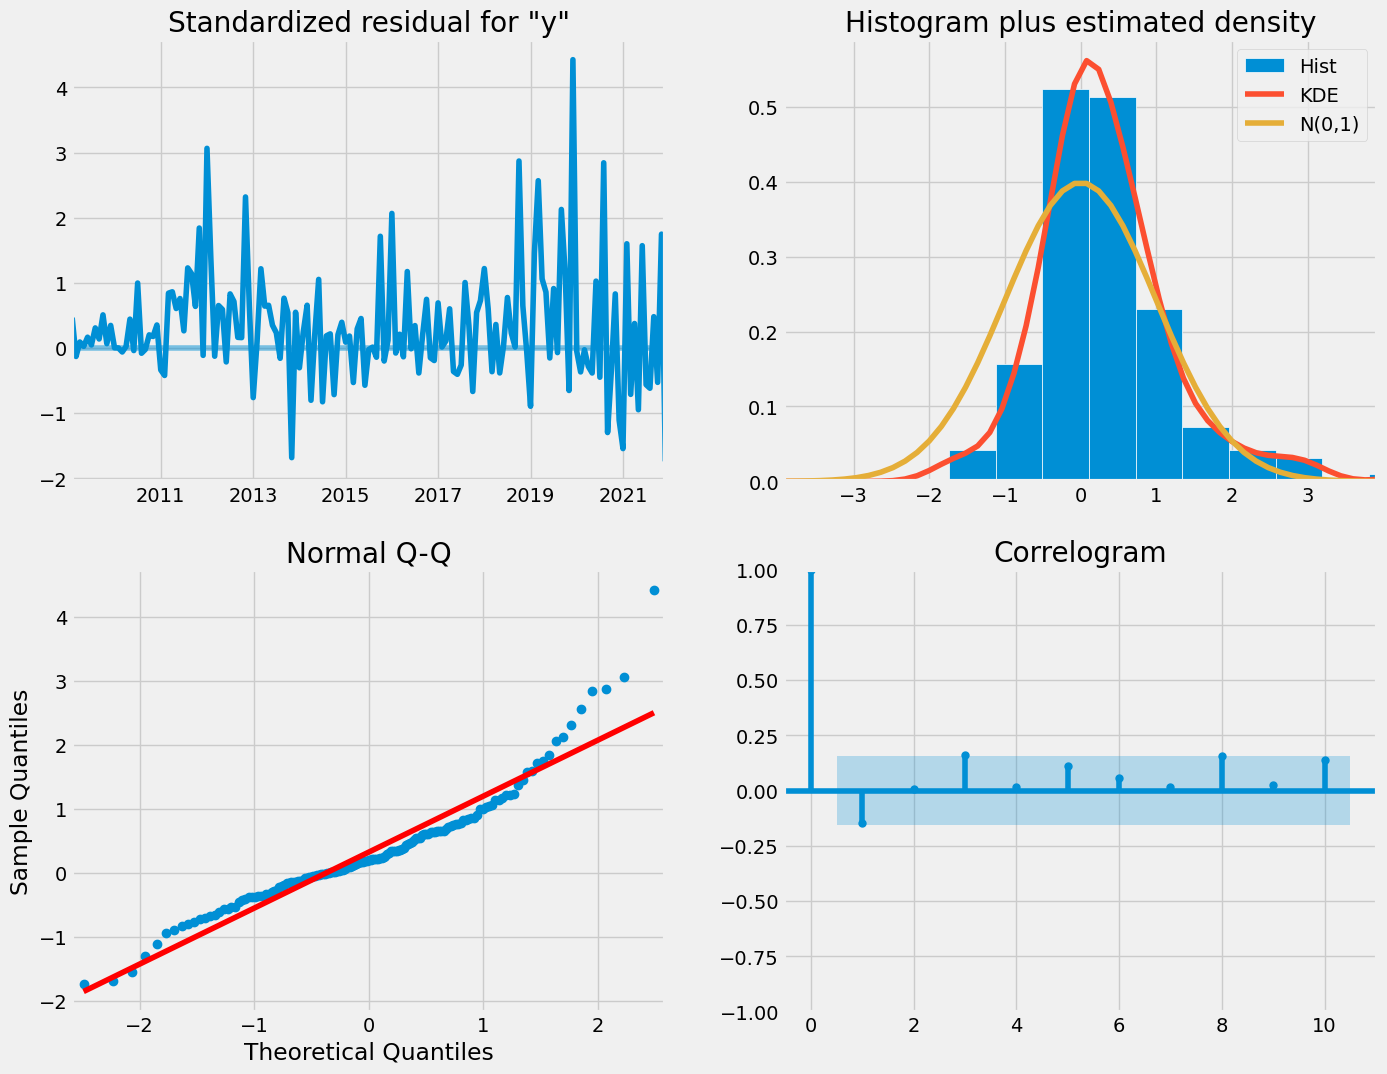

In [19]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

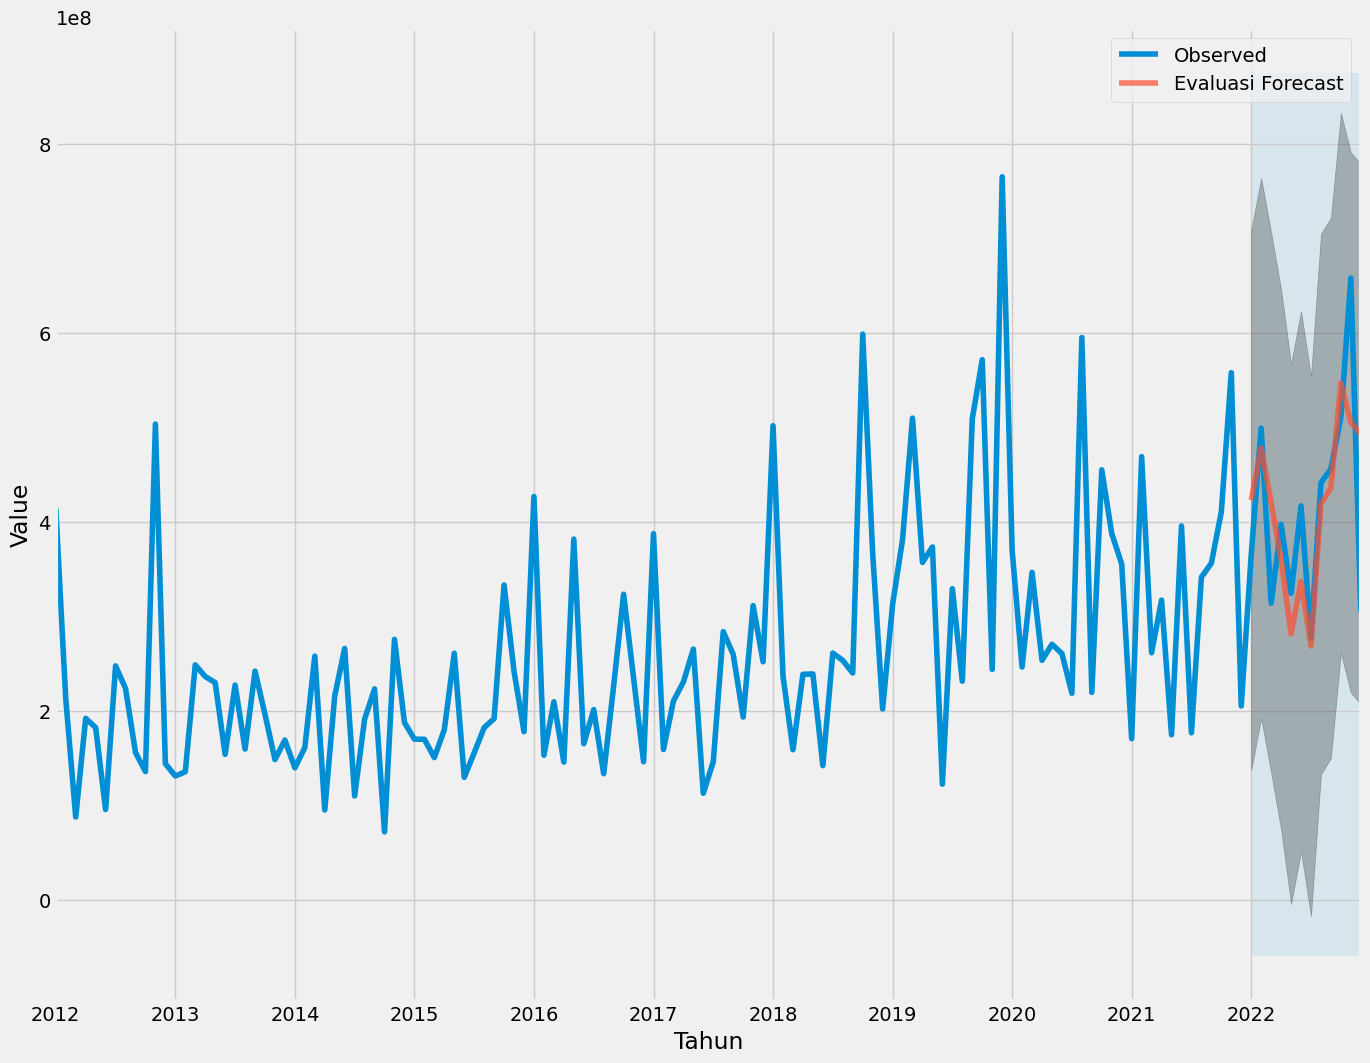

In [13]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [14]:
df_test = df[df.tahun.between('2022-01', '2022-12')]
dts_test = pd.Series(data=df_test['jml_setor'].values, index=df_test['tahun'])
y_test, pred_ahead = np.array(dts_test), np.array(pred.predicted_mean)
list_ape = []
for index, elem in np.ndenumerate(pred_ahead):
    ape = np.abs(elem-y_test[index]) / y_test[index]
    list_ape.append(ape*100)
mape = np.mean(list_ape)
print(list_ape)
print(mape)

[15.872475856007373, 4.203006606052567, 33.91695431257702, 9.380543283748937, 13.24344561015883, 19.23452829593525, 2.9427693497068406, 5.108366235188897, 4.430005421894485, 7.1125863795160065, 23.214810816129624, 61.69816817473666]
16.696471695137706


# Prediksi data selama 2 tahun

In [22]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=24, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()



json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/reklame_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":262690302.6561895311,"2022-02-01T00:00:00.000":372221968.8547653556,"2022-03-01T00:00:00.000":303451908.9312980175,"2022-04-01T00:00:00.000":294685008.0136306286,"2022-05-01T00:00:00.000":232263628.0737500489,"2022-06-01T00:00:00.000":300013713.6629728079,"2022-07-01T00:00:00.000":209577550.3595589399,"2022-08-01T00:00:00.000":379857695.9049389362,"2022-09-01T00:00:00.000":327216716.0648320913,"2022-10-01T00:00:00.000":442460394.8634245992,"2022-11-01T00:00:00.000":451138586.8272373676,"2022-12-01T00:00:00.000":309989738.8257257938,"2023-01-01T00:00:00.000":264376443.929903388,"2023-02-01T00:00:00.000":372249029.9908506274,"2023-03-01T00:00:00.000":303452343.2395601273,"2023-04-01T00:00:00.000":294685014.9839095473,"2023-05-01T00:00:00.000":232263628.1856171191,"2023-06-01T00:00:00.000":300013713.6647681594,"2023-07-01T00:00:00.000":209577550.3595877588,"2023-08-01T00:00:00.000":379857695.9049394131,"2023-09-01T00:00:00.000":327216716.0648320913,"2023-10-01T0

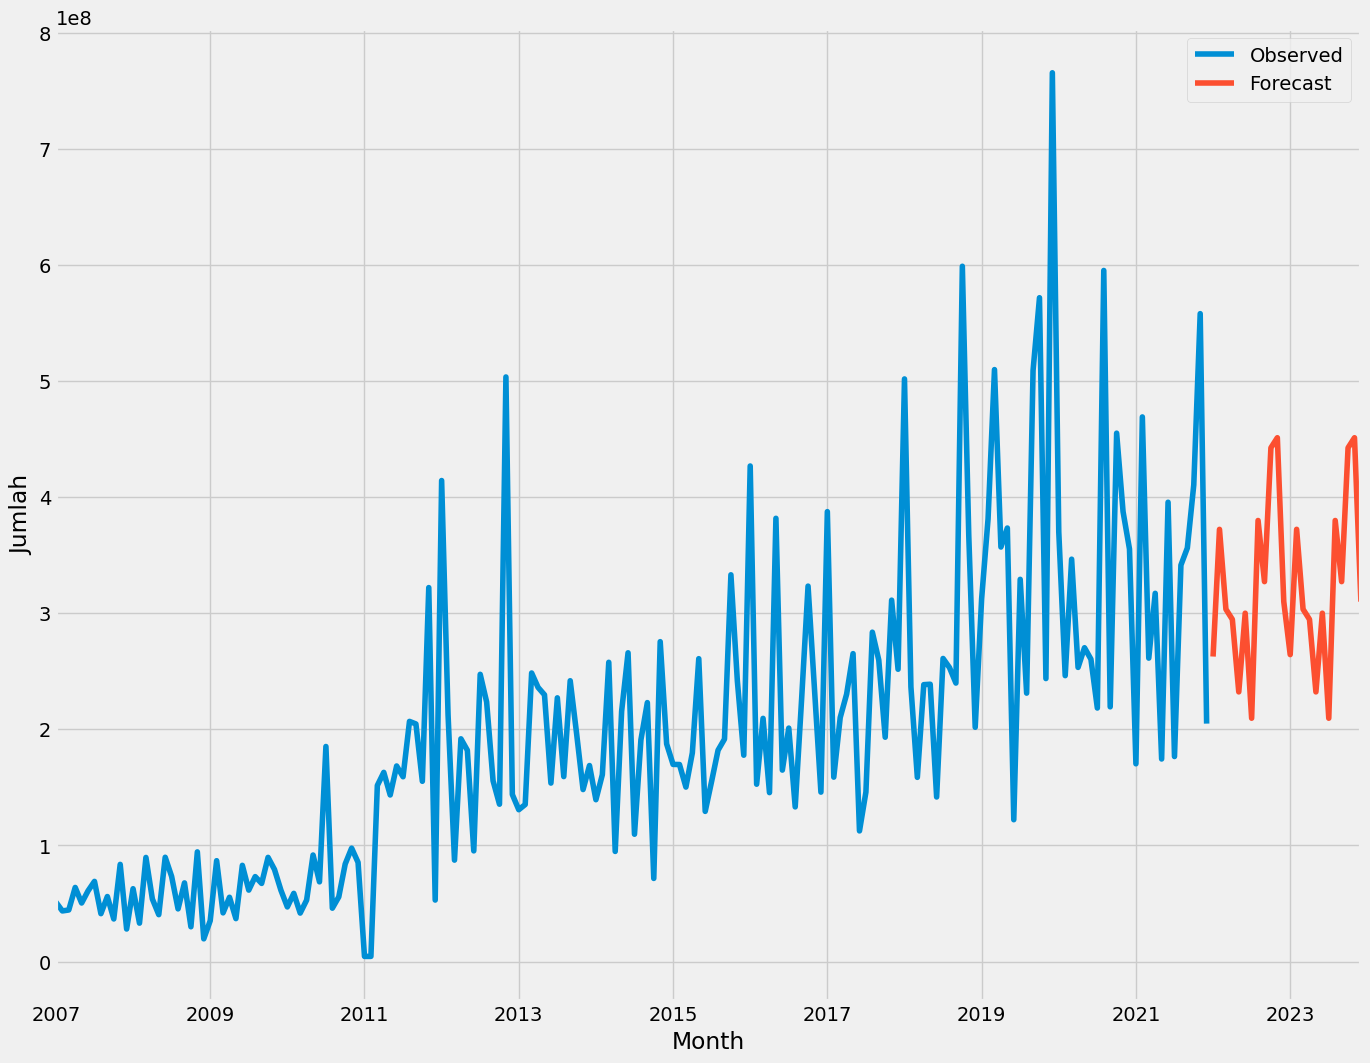

In [23]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()